# Use Feature Tools' Deap Feature Synthesis For Trnasaction Amount Prediction
This notebook uses the [5-minte quickstart guide by FeatureTools](https://docs.featuretools.com/index.html).

## Deep Feature Synthesis

In [57]:
#feature tools
import featuretools as ft

#statistical
import pandas as pd
import numpy as np

#dataset
from sklearn.datasets import *

#mchine learning
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, classification_report
from sklearn.model_selection import learning_curve, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline

#graphing and display
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output
%matplotlib inline
from pprint import pprint

In [58]:
data = ft.demo.load_mock_customer()

In [59]:
customers = data['customers']

In [60]:
customers

,customer_id,zip_code,join_date,date_of_birth
0,1,60091,2011-04-17 10:48:33,1994-07-18
1,2,13244,2012-04-15 23:31:04,1986-08-18
2,3,13244,2011-08-13 15:42:34,2003-11-21
3,4,60091,2011-04-08 20:08:14,2006-08-15
4,5,60091,2010-07-17 05:27:50,1984-07-28


In [61]:
sessions = data['sessions']

In [62]:
sessions.head()

,session_id,customer_id,device,session_start
0,1,2,desktop,2014-01-01 00:00:00
1,2,5,mobile,2014-01-01 00:17:20
2,3,4,mobile,2014-01-01 00:28:10
3,4,1,mobile,2014-01-01 00:44:25
4,5,4,mobile,2014-01-01 01:11:30


In [63]:
transactions = data['transactions']

In [64]:
transactions.head()

,transaction_id,session_id,transaction_time,product_id,amount
0,298,1,2014-01-01 00:00:00,5,127.64
1,2,1,2014-01-01 00:01:05,2,109.48
2,308,1,2014-01-01 00:02:10,3,95.06
3,116,1,2014-01-01 00:03:15,4,78.92
4,371,1,2014-01-01 00:04:20,3,31.54


In [65]:
entities = {'customers': (customers, 'customer_id'),
            'sessions': (sessions, 'session_id'),
            'transactions': (transactions, 'transaction_id', 'transaction_time')}

In [66]:
relationships = [('sessions', 'session_id', 'transactions', 'session_id'),
                 ('customers', 'customer_id', 'sessions', 'customer_id')]

In [67]:
feature_matrix, feature_defs = ft.dfs(entities = entities,
                                                relationships = relationships,
                                                target_entity = 'sessions')

## Exploratory Data Analysis

In [68]:
feature_matrix.head()

,customer_id,device,SUM(transactions.amount),STD(transactions.amount),MAX(transactions.amount),SKEW(transactions.amount),MIN(transactions.amount),MEAN(transactions.amount),COUNT(transactions),NUM_UNIQUE(transactions.product_id),...,customers.NUM_UNIQUE(transactions.product_id),customers.MODE(transactions.product_id),customers.DAY(join_date),customers.DAY(date_of_birth),customers.YEAR(join_date),customers.YEAR(date_of_birth),customers.MONTH(join_date),customers.MONTH(date_of_birth),customers.WEEKDAY(join_date),customers.WEEKDAY(date_of_birth)
session_id,,,,,,,,,,,,,,,,,,,,,
1,2,desktop,1229.01,41.600976,141.66,0.295458,20.91,76.813125,16,5,...,5,4,15,18,2012,1986,4,8,6,0
2,5,mobile,746.96,45.893591,135.25,-0.160550,9.32,74.696000,10,5,...,5,5,17,28,2010,1984,7,7,5,5
3,4,mobile,1329.00,46.240016,147.73,-0.324012,8.70,88.600000,15,5,...,5,2,8,15,2011,2006,4,8,4,1
4,1,mobile,1613.93,40.187205,129.00,0.234349,6.29,64.557200,25,5,...,5,4,17,18,2011,1994,4,7,6,0
5,4,mobile,777.02,48.918663,139.20,0.336381,7.43,70.638182,11,5,...,5,2,8,15,2011,2006,4,8,4,1


In [69]:
feature_matrix.device.unique()

array(['desktop', 'mobile', 'tablet'], dtype=object)

In [70]:
encoder = OneHotEncoder()
encoder.fit(feature_matrix[['device']])

OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=True)

In [71]:
devices = pd.DataFrame(encoder.transform(feature_matrix[['device']]).toarray(),
                       columns = encoder.get_feature_names(),
                       index = feature_matrix.index)

In [72]:
devices.head()

,x0_desktop,x0_mobile,x0_tablet
session_id,,,
1,1.0,0.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
5,0.0,1.0,0.0


In [74]:
feature_matrix = feature_matrix.drop(['device', 'customer_id'], axis = 1).join(devices)

In [75]:
feature_matrix.head()

,SUM(transactions.amount),STD(transactions.amount),MAX(transactions.amount),SKEW(transactions.amount),MIN(transactions.amount),MEAN(transactions.amount),COUNT(transactions),NUM_UNIQUE(transactions.product_id),MODE(transactions.product_id),DAY(session_start),...,customers.DAY(date_of_birth),customers.YEAR(join_date),customers.YEAR(date_of_birth),customers.MONTH(join_date),customers.MONTH(date_of_birth),customers.WEEKDAY(join_date),customers.WEEKDAY(date_of_birth),x0_desktop,x0_mobile,x0_tablet
session_id,,,,,,,,,,,,,,,,,,,,,
1,1229.01,41.600976,141.66,0.295458,20.91,76.813125,16,5,3,1,...,18,2012,1986,4,8,6,0,1.0,0.0,0.0
2,746.96,45.893591,135.25,-0.160550,9.32,74.696000,10,5,5,1,...,28,2010,1984,7,7,5,5,0.0,1.0,0.0
3,1329.00,46.240016,147.73,-0.324012,8.70,88.600000,15,5,1,1,...,15,2011,2006,4,8,4,1,0.0,1.0,0.0
4,1613.93,40.187205,129.00,0.234349,6.29,64.557200,25,5,5,1,...,18,2011,1994,4,7,6,0,0.0,1.0,0.0
5,777.02,48.918663,139.20,0.336381,7.43,70.638182,11,5,5,1,...,15,2011,2006,4,8,4,1,0.0,1.0,0.0


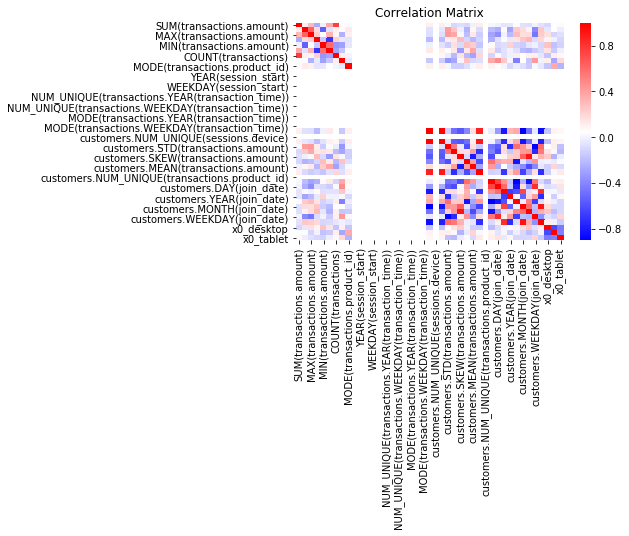

In [79]:
plt.title('Correlation Matrix')
sns.heatmap(feature_matrix.corr(), cmap = 'bwr')

In [92]:
feature_matrix.corr()['SUM(transactions.amount)'][21:]

customers.COUNT(sessions)                        0.107471
customers.NUM_UNIQUE(sessions.device)                 NaN
customers.SUM(transactions.amount)               0.120894
customers.STD(transactions.amount)               0.022273
customers.MAX(transactions.amount)              -0.093248
customers.SKEW(transactions.amount)             -0.073332
customers.MIN(transactions.amount)              -0.096889
customers.MEAN(transactions.amount)             -0.008251
customers.COUNT(transactions)                    0.122180
customers.NUM_UNIQUE(transactions.product_id)         NaN
customers.MODE(transactions.product_id)          0.016681
customers.DAY(join_date)                         0.002688
customers.DAY(date_of_birth)                    -0.048093
customers.YEAR(join_date)                       -0.039644
customers.YEAR(date_of_birth)                    0.041161
customers.MONTH(join_date)                      -0.067836
customers.MONTH(date_of_birth)                  -0.074808
customers.WEEK

In [93]:
corr_threshold = .1
to_plot = feature_matrix.corr()['SUM(transactions.amount)'][21:]
best_corr = to_plot[(to_plot < -corr_threshold) | (to_plot > corr_threshold)]

In [95]:
best_corr

customers.COUNT(sessions)             0.107471
customers.SUM(transactions.amount)    0.120894
customers.COUNT(transactions)         0.122180
x0_desktop                           -0.104088
Name: SUM(transactions.amount), dtype: float64

## Model Selection

In [97]:
train_sizes, train_scores, test_scores = learning_curve(LinearRegression(),
                                                        feature_matrix[best_corr.index.tolist()],
                                                        feature_matrix['SUM(transactions.amount)'],
                                                        train_sizes = np.arange(0.1, 1, 0.1))

C:\Users\rossr\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [98]:
learning_curve_res = pd.DataFrame(columns = range(train_scores.shape[1]))
for result, result_type in zip([train_scores, test_scores], ['train', 'test']):
    frame = pd.DataFrame(result)
    frame['size'] = train_sizes
    frame['type'] = result_type
    learning_curve_res = learning_curve_res.append(frame, ignore_index = True)

In [99]:
learning_curve_res = learning_curve_res.melt(id_vars = ['size', 'type'], var_name = 'cv_fit', value_name = 'score')

In [100]:
learning_curve_res.head()

,size,type,cv_fit,score
0,2.0,train,0,1.000000
1,4.0,train,0,0.407979
2,6.0,train,0,0.427275
3,9.0,train,0,0.233731
4,11.0,train,0,0.297193


C:\Users\rossr\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


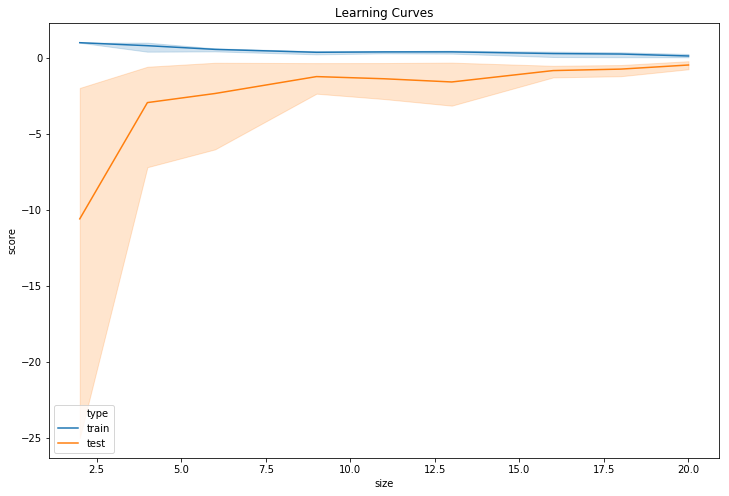

In [101]:
fig = plt.figure(figsize = (12, 8))
plt.title('Learning Curves')
sns.lineplot(x = 'size', y = 'score', hue = 'type', data = learning_curve_res)